In [1]:
# loading package
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier #(選擇對抗造聲強的SVM KNN 隨基森林 考律資料樣本少 使用隨機森林)
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
# loading data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_data = df_train.append(df_test)
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

,Survived
Sex,
female,0.742038
male,0.188908


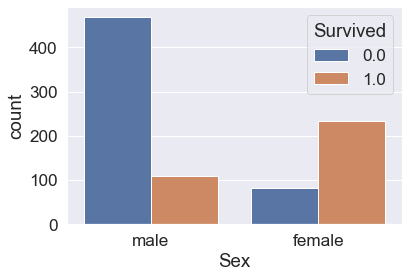

In [2]:
sns.countplot(df_data["Sex"],hue=df_data["Survived"])
display(df_data[["Sex", "Survived"]].groupby(['Sex']).mean())  #性別大概率影響生存率 male:19% female:74%

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


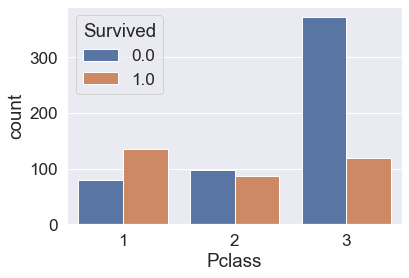

In [3]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass']).mean() #Pclass 越高 越有機會存活

In [4]:
df_data["sex_code"]=df_data["Sex"].map({"female":1,"male":0}).astype("int")

In [5]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [6]:
Base = ['sex_code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=40,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))
#透過調整 random_state 跟 n_estimators 基本上還是在72-74%之間遊走 代表特徵找的不夠充足 甚至直接用性別猜還有78%

Base oob score :0.73176


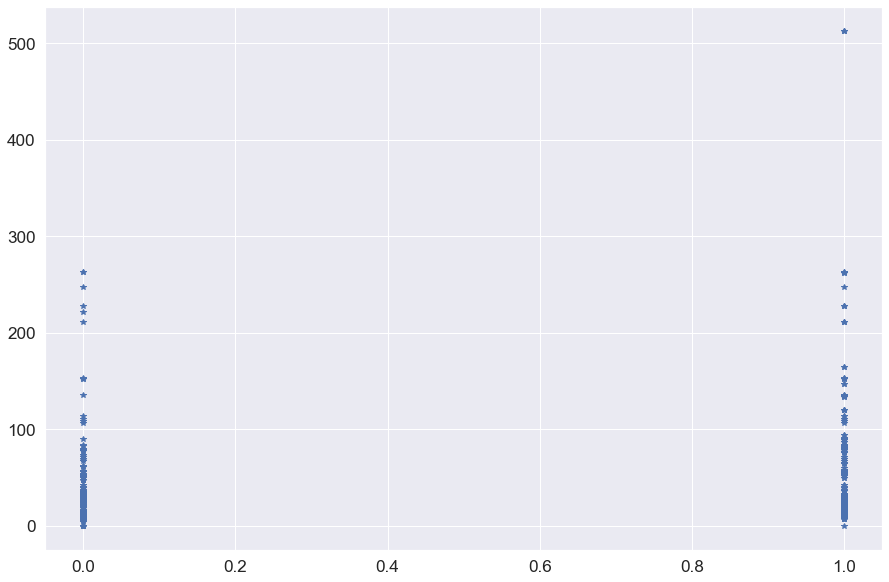

In [7]:
plt.figure(figsize=(15,10))
plt.plot(df_data["Survived"],df_data["Fare"],'*',color="b")

In [8]:
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)

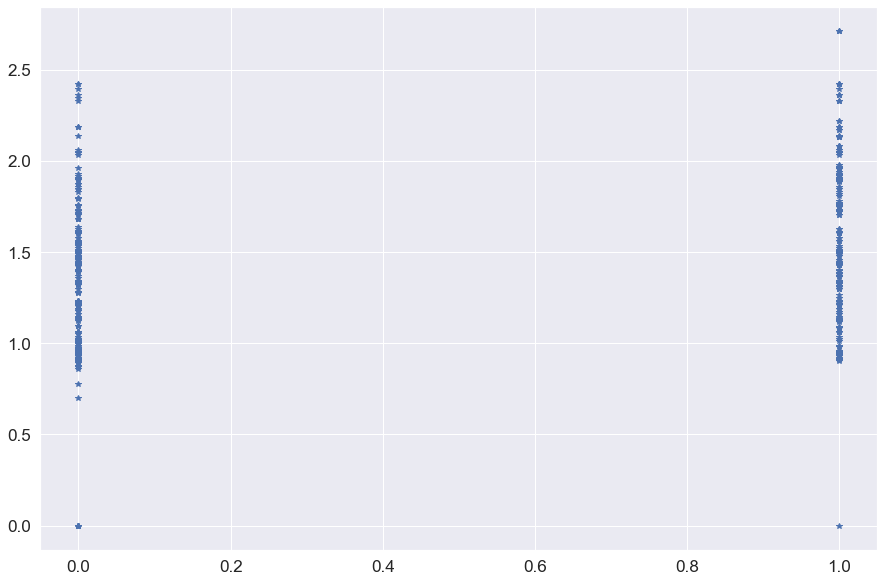

In [9]:
plt.figure(figsize=(15,10))
plt.plot(df_data["Survived"],df_data["Log_Fare"],'*',color="b")

Fare         
Survived    0.0      1.0
Pclass                  
1         44.75  77.9583
2         13.00  21.0000
3          8.05   8.5167

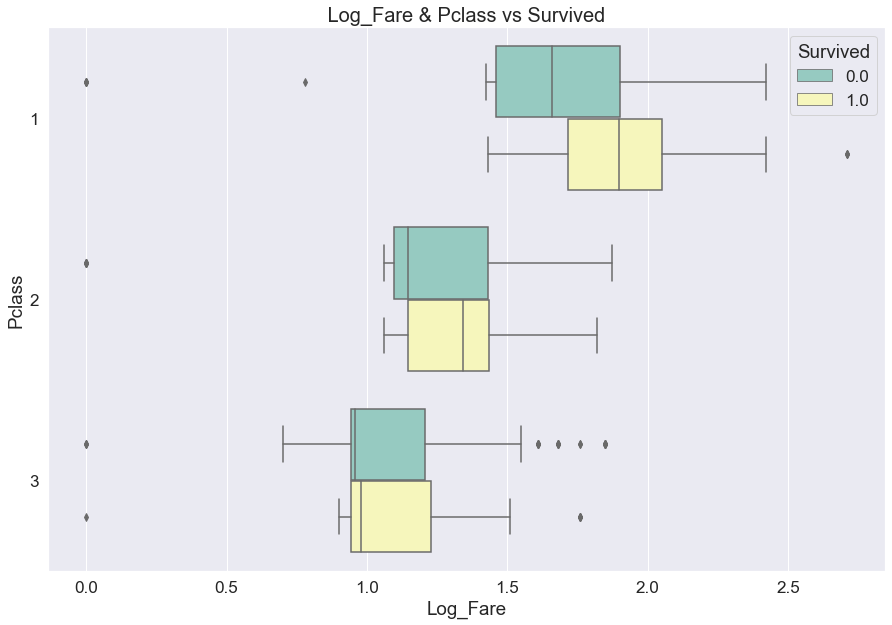

In [10]:
fig, ax = plt.subplots( figsize = (15,10) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=df_data, orient='h'
                ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' )
#票價在31塊(10^1.5)(Pclass1)以上有明顯的差異 在Pclass2的部分可以看到存活下來的人 票價中位數較高  沒辦法很清楚看出差異

In [11]:
df_data['Fare']=df_data["Fare"].fillna(df_data["Fare"].median()) #補缺值

In [12]:
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)   #分段
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)
df_data['FareBin_7'] = pd.qcut(df_data['Fare'], 7)

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


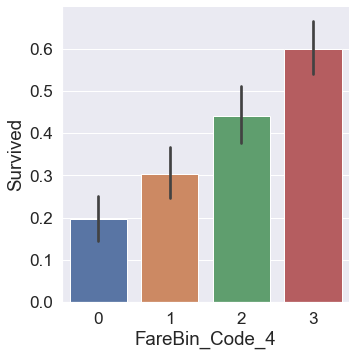

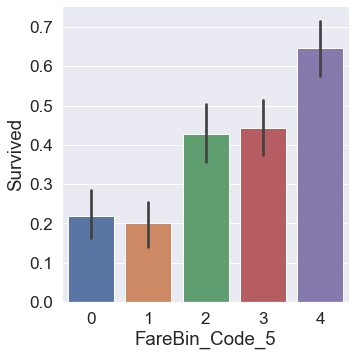

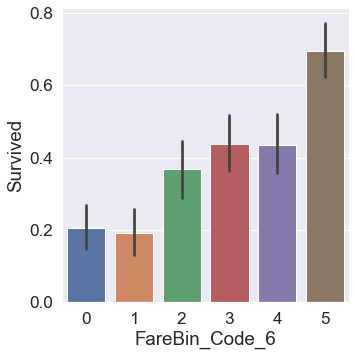

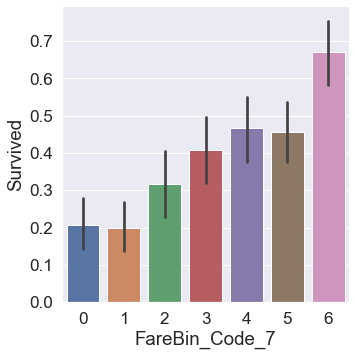

In [15]:
label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])
df_data['FareBin_Code_7'] = label.fit_transform(df_data['FareBin_7'])

df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])
df_7 = pd.crosstab(df_data['FareBin_Code_7'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6,df_7)



g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data,kind='bar',ax=df_4)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data,kind='bar',ax=df_5)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data,kind='bar',ax=df_6)
g4 = sns.factorplot(x='FareBin_Code_7', y="Survived", data=df_data,kind='bar',ax=df_7)



In [16]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [17]:
compare = ['sex_code','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6','FareBin_Code_7']
selector = RFECV(RandomForestClassifier(n_estimators=300,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)
#票價影響並不大 只看性別 也有78%

[ True  True False  True  True  True]
[1 1 2 1 1 1]
[78.67290886 77.33208489 79.3545568  79.24344569 80.58926342 80.02621723]


In [55]:
df_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,sex_code,Log_Fare,FareBin_4,FareBin_5,FareBin_6,FareBin_7,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,FareBin_Code_7
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]","(-0.001, 7.75]",0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]","(59.4, 512.329]",3,4,5,6
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]","(7.75, 8.05]",1,1,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]","(27.793, 59.4]",3,4,4,5
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]","(7.75, 8.05]",1,1,1,1
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,...,0,0.975813,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]","(8.05, 12.875]",1,1,1,2
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,1.723148,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]","(27.793, 59.4]",3,4,4,5
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,0,1.343901,"(14.454, 31.275]","(10.5, 21.558]","(14.454, 26.0]","(19.258, 27.793]",2,2,3,4
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,1,1.083979,"(7.896, 14.454]","(10.5, 21.558]","(8.662, 14.454]","(8.05, 12.875]",1,2,2,2
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,1,1.492352,"(14.454, 31.275]","(21.558, 41.579]","(26.0, 53.1]","(27.793, 59.4]",2,3,4,5


In [18]:
b4, b5, b6, b7 = ['sex_code', 'Pclass','FareBin_Code_4'], ['sex_code','Pclass','FareBin_Code_5'],['sex_code','Pclass','FareBin_Code_6'],['sex_code', 'Pclass','FareBin_Code_7']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=400,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=400,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=400,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
b7_Model = RandomForestClassifier(random_state=2,n_estimators=400,min_samples_split=20,oob_score=True)
b7_Model.fit(X[b7], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')
print('b7 oob score : %.5f' %(b7_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.79798   LB_Public : 0.77033
b7 oob score : 0.79574   LB_Public : 0.77033


In [19]:
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

b5_pred = b5_Model.predict(X_Submit[b5])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":b5_pred.astype(int)})
submit.to_csv("submit_b5.csv",index=False)

In [20]:
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)

In [21]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [22]:
df_data['Connected_Survival'] = 0.5 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [23]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
connect = ['sex_code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


Text(1.0, 72.8, '72.8')

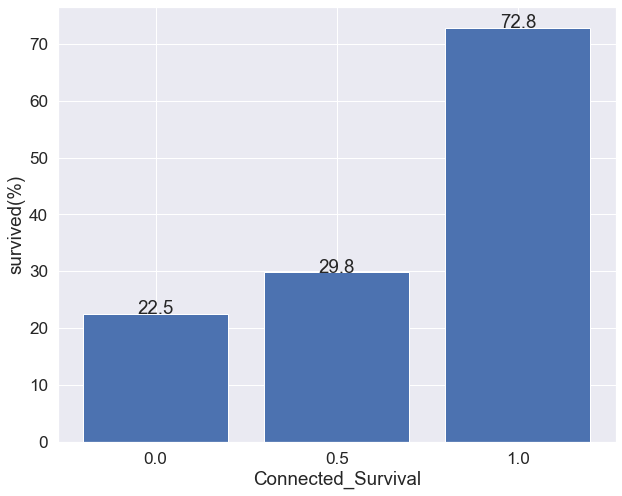

In [42]:
plt.figure(figsize=(10,8))
plt.ylabel("survived(%)")
plt.xlabel("Connected_Survival")
plt.bar(['0.0','0.5','1.0'],[22.5,29.8,72.8],color="b")
plt.text("0.0",22.5,22.5,ha="center")
plt.text("0.5",29.8,29.8,ha="center")
plt.text("1.0",72.8,72.8,ha="center")